In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split

In [2]:
spark = SparkSession.builder \
    .appName("Project Milestone 1") \
    .getOrCreate()

24/11/16 17:21:08 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s17)
24/11/16 17:21:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/16 17:21:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")

24/11/16 17:21:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
business_df.write.parquet("file:///home/dps/Documents/temp/business_parquet")
business_df = spark.read.parquet("file:///home/dps/Documents/temp/business_parquet")
az_business_df = business_df.filter(business_df.state == "AZ")
az_business_df.cache()

DataFrame[address: string, attributes: struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>, business_id: string, categories: string, city: string, hours: struct<Friday:string,Monday:string,Saturday:string

In [5]:
distinct_categories = az_business_df.select(explode(split(az_business_df.categories, ", ")).alias("category")) \
    .distinct() \
    .orderBy("category")

distinct_categories.show(n=distinct_categories.count(), truncate=False)

+-----------------------------------+
|category                           |
+-----------------------------------+
|& Probates                         |
|ATV Rentals/Tours                  |
|Acai Bowls                         |
|Accessories                        |
|Accountants                        |
|Acne Treatment                     |
|Active Life                        |
|Acupuncture                        |
|Addiction Medicine                 |
|Adoption Services                  |
|Adult                              |
|Adult Education                    |
|Adult Entertainment                |
|Advertising                        |
|Aerial Fitness                     |
|Aerial Tours                       |
|Aestheticians                      |
|Afghan                             |
|African                            |
|Air Duct Cleaning                  |
|Airlines                           |
|Airport Shuttles                   |
|Airports                           |
|Airsoft    

In [6]:
az_airport_shuttles_df = az_business_df.filter(az_business_df.categories.contains("Airport Shuttles"))
az_airport_shuttles_df.createOrReplaceTempView("az_airport_shuttles")
print("Number of airport shuttle businesses in Arizona:")
az_airport_shuttles_df.count()

Number of airport shuttle businesses in Arizona:


24

In [7]:
print("Basic statistics of Airport Shuttle businesses in Arizona:")
az_airport_shuttles_df.select("stars", "review_count").describe().show()

print("\nSchema of the Airport Shuttles dataframe:")
az_airport_shuttles_df.printSchema()

Basic statistics of Airport Shuttle businesses in Arizona:
+-------+------------------+------------------+
|summary|             stars|      review_count|
+-------+------------------+------------------+
|  count|                24|                24|
|   mean| 4.083333333333333|             19.75|
| stddev|1.0179547554081032|17.725564932433407|
|    min|               1.5|                 5|
|    max|               5.0|                80|
+-------+------------------+------------------+


Schema of the Airport Shuttles dataframe:
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |   

In [8]:
from pyspark.sql.functions import col

In [9]:
query1 = """
SELECT name, city, stars, review_count
FROM az_airport_shuttles
ORDER BY stars DESC, review_count DESC
LIMIT 5
"""

result1 = spark.sql(query1)

print("Top 5 Airport Shuttle businesses in Arizona by rating:")
result1.show(truncate=False)

avg_query = "SELECT AVG(stars) as avg_rating FROM az_airport_shuttles"
avg_rating = spark.sql(avg_query).collect()[0]['avg_rating']

print(f"\nAverage rating of Airport Shuttle businesses in Arizona: {avg_rating:.2f}")

Top 5 Airport Shuttle businesses in Arizona by rating:
+--------------------------------+------+-----+------------+
|name                            |city  |stars|review_count|
+--------------------------------+------+-----+------------+
|24hr Express                    |Tucson|5.0  |23          |
|Limoport Transportation         |Tucson|5.0  |17          |
|UNO Transportation              |Tucson|5.0  |11          |
|Town Cars                       |Tucson|5.0  |8           |
|LeChic Transport & Limo Services|Tucson|5.0  |6           |
+--------------------------------+------+-----+------------+


Average rating of Airport Shuttle businesses in Arizona: 4.08


In [10]:
import matplotlib.pyplot as plt

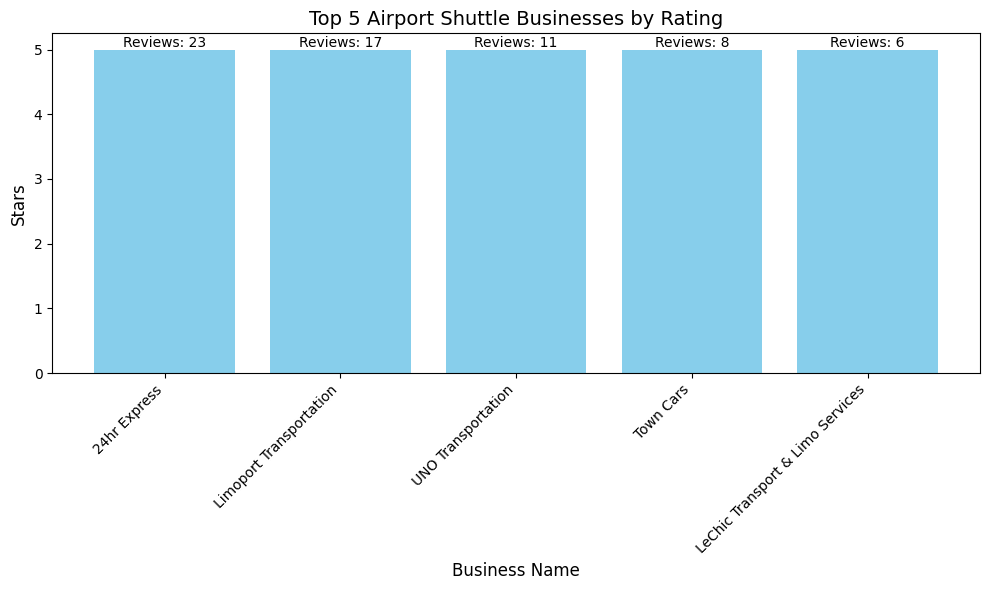

In [11]:
top_5_df = result1.toPandas()

plt.figure(figsize=(10, 6))
bars = plt.bar(top_5_df['name'], top_5_df['stars'], color='skyblue', label='Stars')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f"Reviews: {top_5_df['review_count'][i]}", 
             ha='center', va='bottom', fontsize=10)

plt.title('Top 5 Airport Shuttle Businesses by Rating', fontsize=14)
plt.xlabel('Business Name', fontsize=12)
plt.ylabel('Stars', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
query2 = """
SELECT AVG(review_count) as avg_review_count
FROM az_airport_shuttles
"""

result2 = spark.sql(query2)

print("Average review count for Airport Shuttle businesses in Arizona:")
result2.show()

avg_review_count = result2.collect()[0]['avg_review_count']
print(f"\nThe average number of reviews per Airport Shuttle business is: {avg_review_count:.2f}")

Average review count for Airport Shuttle businesses in Arizona:
+----------------+
|avg_review_count|
+----------------+
|           19.75|
+----------------+


The average number of reviews per Airport Shuttle business is: 19.75


In [13]:
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
review_df.createOrReplaceTempView("reviews")

In [14]:
query3 = """
SELECT 
    b.name,
    b.city,
    AVG(r.stars) as avg_rating,
    AVG(LENGTH(r.text)) as avg_review_length,
    COUNT(r.review_id) as review_count
FROM 
    az_airport_shuttles b
JOIN 
    reviews r ON b.business_id = r.business_id
GROUP BY 
    b.business_id, b.name, b.city
ORDER BY 
    avg_rating DESC, review_count DESC
"""

result3 = spark.sql(query3)

print("Average rating and review length for Airport Shuttle businesses in Arizona:")
result3.show(truncate=False)


overall_avg_rating = result3.agg({"avg_rating": "avg"}).collect()[0][0]
print(f"\nOverall average rating: {overall_avg_rating:.2f}")

overall_avg_review_length = result3.agg({"avg_review_length": "avg"}).collect()[0][0]
print(f"Overall average review length: {overall_avg_review_length:.2f} characters")

Average rating and review length for Airport Shuttle businesses in Arizona:


+----------------------------------+------+------------------+------------------+------------+
|name                              |city  |avg_rating        |avg_review_length |review_count|
+----------------------------------+------+------------------+------------------+------------+
|24hr Express                      |Tucson|5.0               |385.7391304347826 |23          |
|UNO Transportation                |Tucson|5.0               |534.9166666666666 |12          |
|Town Cars                         |Tucson|5.0               |384.0             |8           |
|King Pin Cab Company              |Tucson|5.0               |385.6666666666667 |6           |
|Diamond Transportation            |Tucson|5.0               |346.1666666666667 |6           |
|LeChic Transport & Limo Services  |Tucson|5.0               |384.1666666666667 |6           |
|Limoport Transportation           |Tucson|4.882352941176471 |566.5294117647059 |17          |
|Tucson Resort Transportation      |Tuscon|4.72222


Overall average rating: 4.05


Overall average review length: 500.61 characters


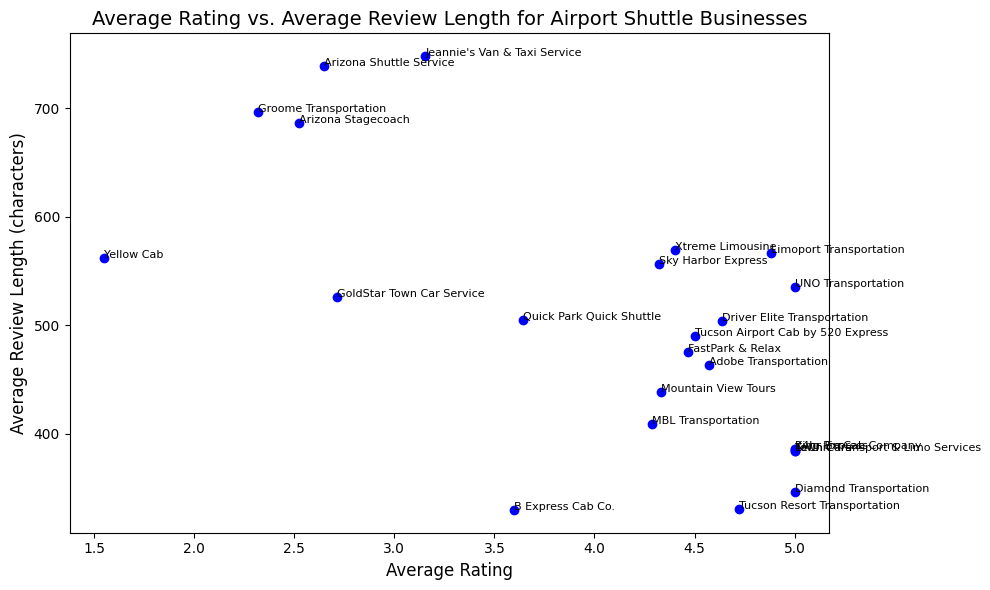

In [15]:
business_names = [row['name'] for row in result3.collect()]
avg_ratings = [row['avg_rating'] for row in result3.collect()]
avg_review_lengths = [row['avg_review_length'] for row in result3.collect()]

plt.figure(figsize=(10, 6))
plt.scatter(avg_ratings, avg_review_lengths, color='blue')
plt.title('Average Rating vs. Average Review Length for Airport Shuttle Businesses', fontsize=14)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Average Review Length (characters)', fontsize=12)

for i, name in enumerate(business_names):
    plt.annotate(name, (avg_ratings[i], avg_review_lengths[i]), fontsize=8)

plt.tight_layout()
plt.show()

In [16]:
from pyspark.sql.functions import year

In [17]:
review_with_year = review_df.withColumn("review_year", year("date"))
review_with_year.createOrReplaceTempView("reviews_with_year")

query4 = """
SELECT 
    r.review_year,
    COUNT(r.review_id) as total_reviews,
    AVG(r.stars) as avg_rating,
    AVG(LENGTH(r.text)) as avg_review_length
FROM 
    reviews_with_year r
JOIN 
    az_airport_shuttles b ON r.business_id = b.business_id
GROUP BY 
    r.review_year
ORDER BY 
    r.review_year ASC
"""

result4 = spark.sql(query4)

print("Review trends over the years for Airport Shuttle businesses:")
result4.show(truncate=False)

Review trends over the years for Airport Shuttle businesses:


+-----------+-------------+------------------+------------------+
|review_year|total_reviews|avg_rating        |avg_review_length |
+-----------+-------------+------------------+------------------+
|2008       |3            |3.6666666666666665|775.6666666666666 |
|2009       |7            |2.2857142857142856|623.5714285714286 |
|2010       |9            |3.111111111111111 |836.6666666666666 |
|2011       |24           |3.25              |711.375           |
|2012       |36           |3.3055555555555554|709.1111111111111 |
|2013       |35           |3.5714285714285716|548.2             |
|2014       |30           |3.933333333333333 |606.2333333333333 |
|2015       |77           |3.935064935064935 |504.5584415584416 |
|2016       |67           |3.8955223880597014|518.8656716417911 |
|2017       |56           |3.8035714285714284|502.48214285714283|
|2018       |55           |3.4909090909090907|545.1818181818181 |
|2019       |48           |3.5625            |535.625           |
|2020     

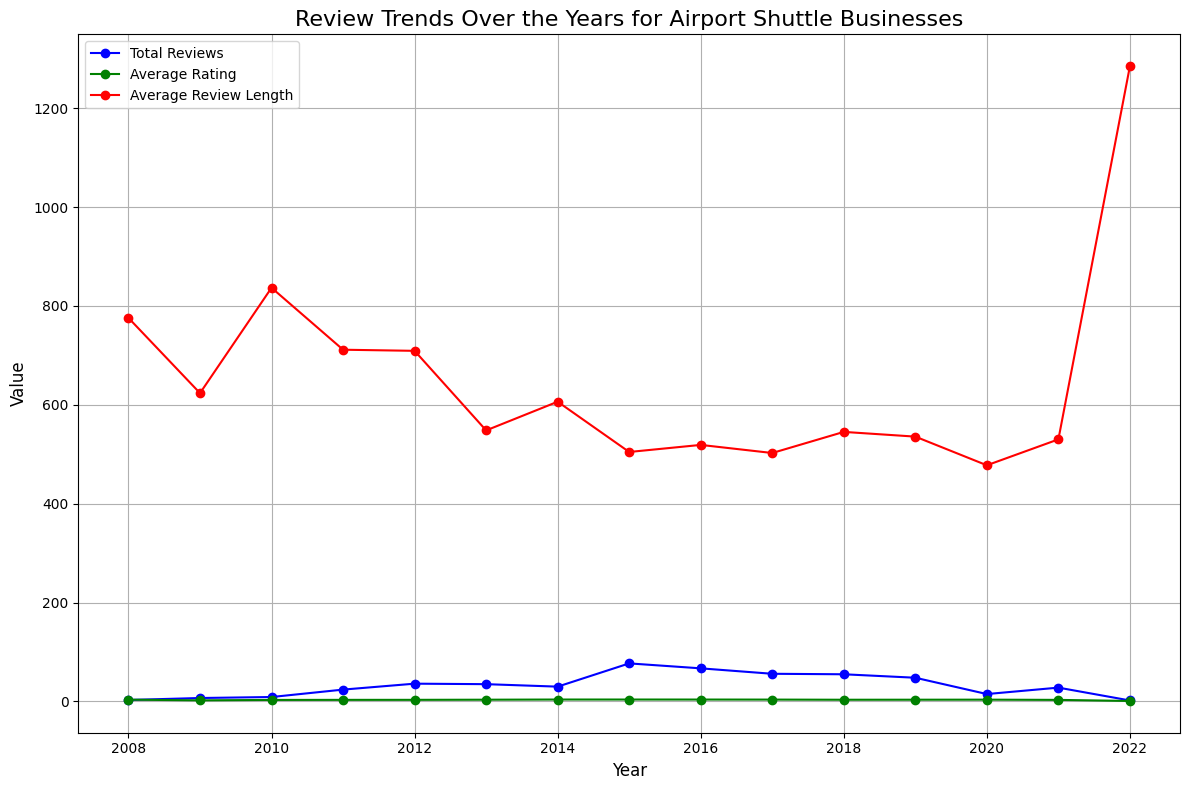

In [18]:
years = [row['review_year'] for row in result4.collect()]
total_reviews = [row['total_reviews'] for row in result4.collect()]
avg_ratings = [row['avg_rating'] for row in result4.collect()]
avg_review_lengths = [row['avg_review_length'] for row in result4.collect()]

plt.figure(figsize=(12, 8))
plt.plot(years, total_reviews, label='Total Reviews', color='b', marker='o')
plt.plot(years, avg_ratings, label='Average Rating', color='g', marker='o')
plt.plot(years, avg_review_lengths, label='Average Review Length', color='r', marker='o')
plt.title('Review Trends Over the Years for Airport Shuttle Businesses', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

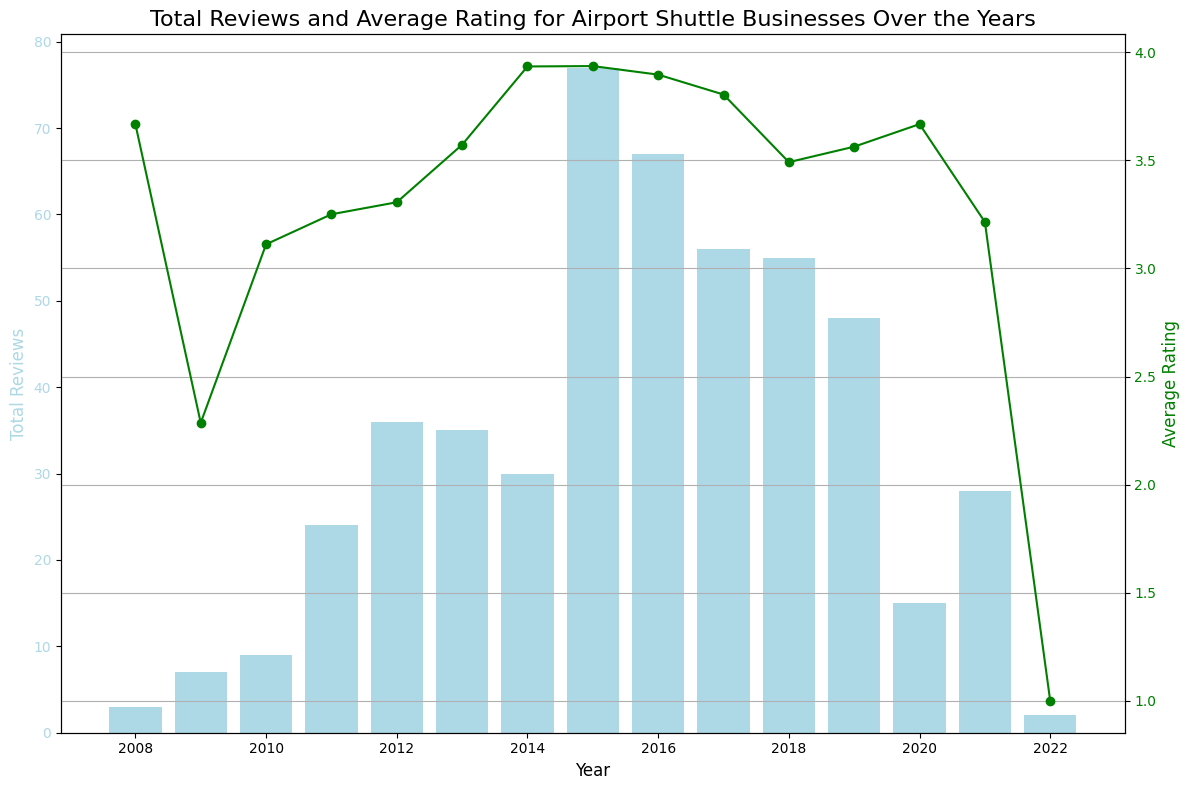

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.bar(years, total_reviews, color='lightblue', label='Total Reviews')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Reviews', fontsize=12, color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')
ax2 = ax1.twinx()
ax2.plot(years, avg_ratings, color='g', label='Average Rating', marker='o')
ax2.set_ylabel('Average Rating', fontsize=12, color='g')
ax2.tick_params(axis='y', labelcolor='g')
plt.title('Total Reviews and Average Rating for Airport Shuttle Businesses Over the Years', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

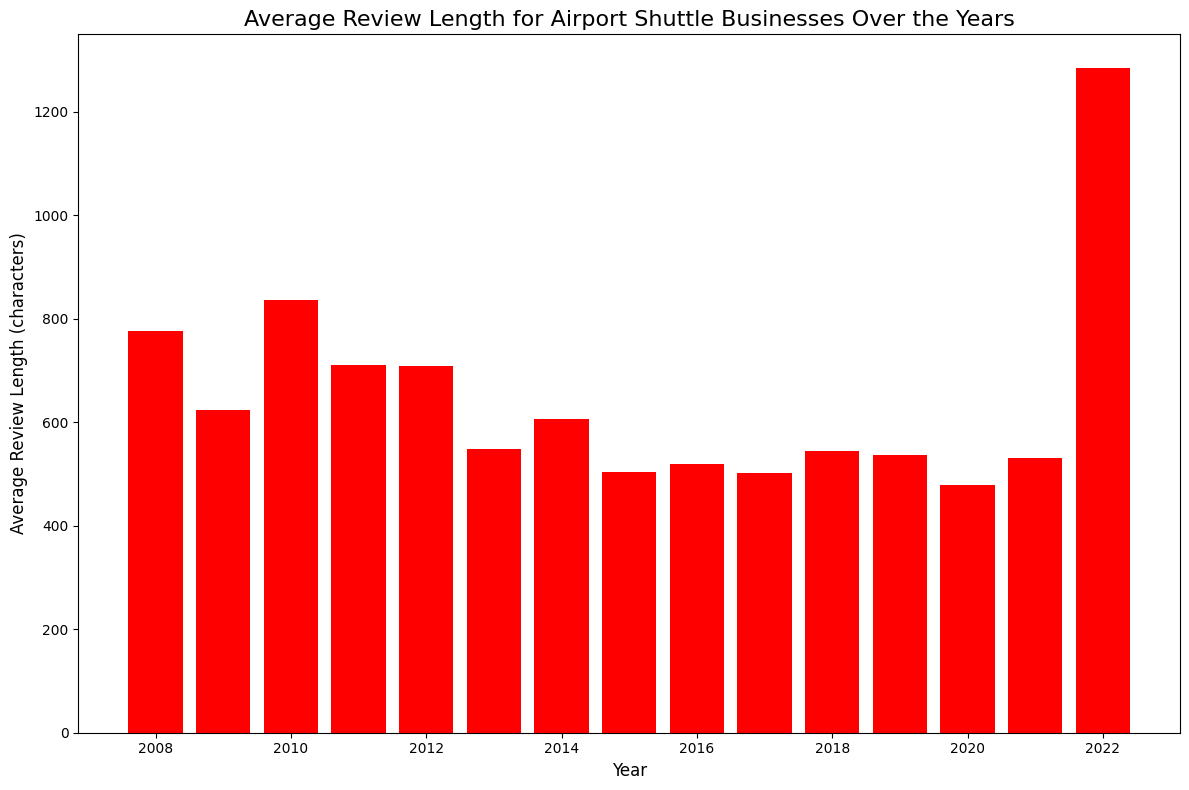

In [20]:
plt.figure(figsize=(12, 8))
plt.bar(years, avg_review_lengths, color='r', label='Average Review Length')
plt.title('Average Review Length for Airport Shuttle Businesses Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Review Length (characters)', fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
query5 = """
SELECT 
    b.name,
    b.city,
    b.stars as avg_business_rating,
    b.review_count as total_reviews,
    AVG(LENGTH(r.text)) as avg_review_length,
    COUNT(r.review_id) as total_review_engagement
FROM 
    az_airport_shuttles b
JOIN 
    reviews r ON b.business_id = r.business_id
GROUP BY 
    b.business_id, b.name, b.city, b.stars, b.review_count
ORDER BY 
    total_review_engagement DESC, avg_business_rating DESC
LIMIT 10
"""

result5 = spark.sql(query5)

print("Top 10 Airport Shuttle businesses in Arizona by customer engagement:")
result5.show(truncate=False)

Top 10 Airport Shuttle businesses in Arizona by customer engagement:


+----------------------------------+------+-------------------+-------------+------------------+-----------------------+
|name                              |city  |avg_business_rating|total_reviews|avg_review_length |total_review_engagement|
+----------------------------------+------+-------------------+-------------+------------------+-----------------------+
|Arizona Shuttle Service           |Tucson|2.5                |80           |739.109756097561  |82                     |
|FastPark & Relax                  |Tucson|4.5                |43           |475.6170212765957 |47                     |
|Arizona Stagecoach                |Tucson|2.5                |41           |686.3181818181819 |44                     |
|Yellow Cab                        |Tucson|1.5                |40           |561.95            |40                     |
|Sky Harbor Express                |Tucson|4.5                |31           |556.4705882352941 |34                     |
|Tucson Airport Cab by 520 Expre

In [22]:
import pandas as pd

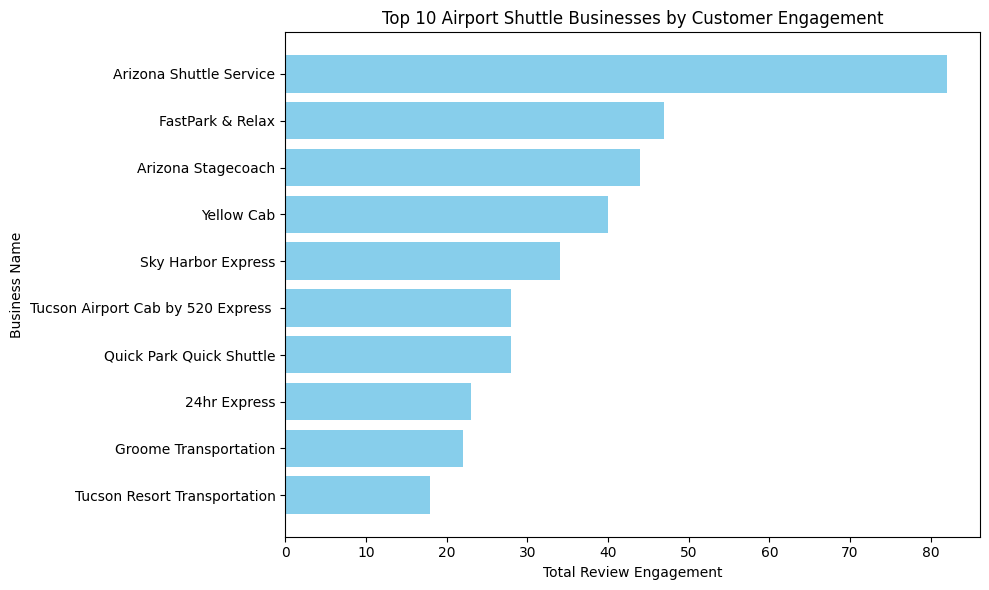

In [23]:
query5_df = result5.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(query5_df['name'], query5_df['total_review_engagement'], color='skyblue')
plt.xlabel('Total Review Engagement')
plt.ylabel('Business Name')
plt.title('Top 10 Airport Shuttle Businesses by Customer Engagement')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
import seaborn as sns

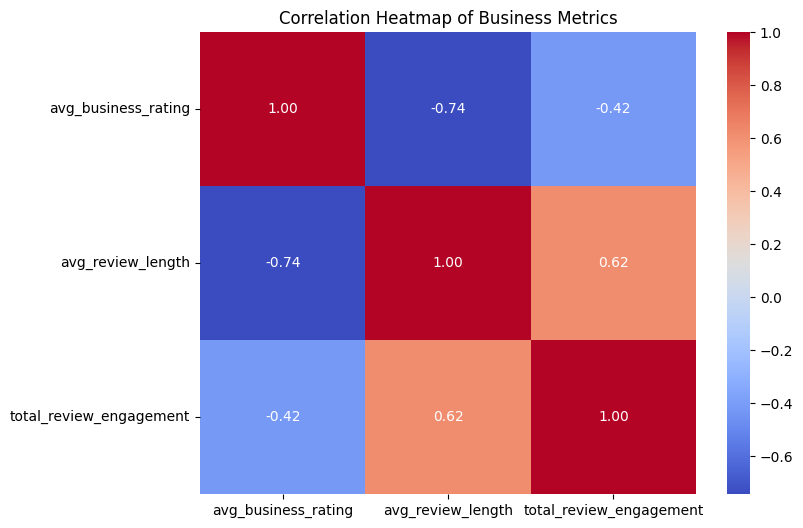

In [25]:
plt.figure(figsize=(8, 6))
correlation_matrix = query5_df[['avg_business_rating', 'avg_review_length', 'total_review_engagement']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Business Metrics')
plt.show()

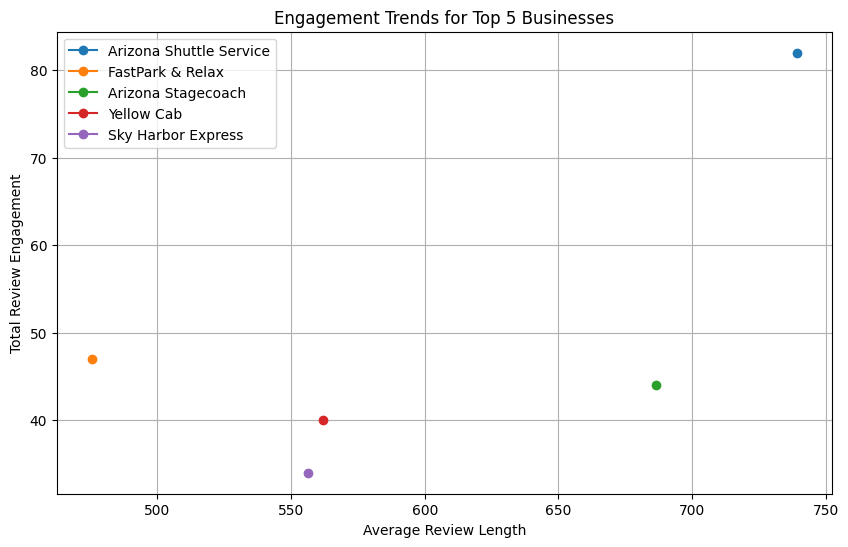

In [26]:
top_5_engagement = query5_df.nlargest(5, 'total_review_engagement')

plt.figure(figsize=(10, 6))

for name in top_5_engagement['name']:
    business_df = query5_df[query5_df['name'] == name]
    plt.plot(business_df['avg_review_length'], business_df['total_review_engagement'], label=name, marker='o')

plt.xlabel('Average Review Length')
plt.ylabel('Total Review Engagement')
plt.title('Engagement Trends for Top 5 Businesses')
plt.legend()
plt.grid(True)
plt.show()